<a href="https://colab.research.google.com/github/joaosiqueira/Data-Science-Resources/blob/master/mapbiomas_alerta_before_and_after_image_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [235]:
# Instalar e autenticar o Google Earth Engine no Colab
import ee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Autenticar e inicializar o GEE
PROJECT_ID = 'mapbiomas'

try:
    ee.Initialize(project=PROJECT_ID)
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)


In [236]:
# AOI = ee.Geometry.Point(-57.87255, -10.03289).buffer(200).bounds()
# AOI = ee.Geometry.Point(-52.68545, -25.31377).buffer(200).bounds()
AOI = ee.Geometry.Point(-46.1816, -8.7013).buffer(200).bounds(10)
# AOI = ee.Geometry.Point(-52.780, -30.995).buffer(200).bounds()

START_DATE = '2018-01-01'
END_DATE = '2024-12-31'
CLOUD_FILTER = 30
CLD_PRB_THRESH = 30
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [237]:
def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

In [238]:
s2_sr_cld_col = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)

collection = (s2_sr_cld_col.map(add_cld_shdw_mask)
                             .map(apply_cld_shdw_mask))

print(collection.size().getInfo())

414


In [239]:
# Função para calcular NDVI
def calc_ndvi(image):
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("NDVI")
    return image.addBands(ndvi)

# Função para extrair os valores do NDVI no ponto
def extract_ndvi(image):
    ndvi_value = image.select("NDVI").reduceRegion(
        reducer=ee.Reducer.mean(), geometry=AOI, scale=10
    )
    return ee.Feature(None, {"date": image.date().format(), "NDVI": ndvi_value.get("NDVI")})


In [240]:
# Aplicar a função NDVI à coleção
ndvi_collection = collection.map(calc_ndvi)

# Aplicar a extração e converter para lista
ndvi_series = ndvi_collection.map(extract_ndvi).filter(ee.Filter.notNull(["NDVI"]))

# Transformar em DataFrame Pandas
ndvi_list = ndvi_series.aggregate_array("NDVI").getInfo()
dates_list = ndvi_series.aggregate_array("date").getInfo()


In [241]:
df = pd.DataFrame({"Date": pd.to_datetime(dates_list), "NDVI": ndvi_list})
df

,Date,NDVI
0,2018-12-19 13:34:30,0.729146
1,2018-12-26 13:24:37,0.626577
2,2019-01-03 13:34:37,0.715896
3,2019-01-28 13:34:36,0.618557
4,2019-01-30 13:24:44,0.661422
...,...,...
395,2024-11-24 13:24:43,0.375419
396,2024-11-27 13:34:37,0.469121
397,2024-11-29 13:24:45,0.494611
398,2024-12-07 13:34:40,0.612344


In [242]:
from scipy.signal import savgol_filter

df["NDVI Savitzky-Golay"] = savgol_filter(df["NDVI"], window_length=7, polyorder=2)
df


,Date,NDVI,NDVI Savitzky-Golay
0,2018-12-19 13:34:30,0.729146,0.717293
1,2018-12-26 13:24:37,0.626577,0.677021
2,2019-01-03 13:34:37,0.715896,0.651973
3,2019-01-28 13:34:36,0.618557,0.642149
4,2019-01-30 13:24:44,0.661422,0.657071
...,...,...,...
395,2024-11-24 13:24:43,0.375419,0.353244
396,2024-11-27 13:34:37,0.469121,0.460310
397,2024-11-29 13:24:45,0.494611,0.529650
398,2024-12-07 13:34:40,0.612344,0.578047


In [243]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess(df["NDVI"], df["Date"], frac=0.1)
df["NDVI Interpolação & LOESS (Lowess)"] = lowess[:, 1]
df

,Date,NDVI,NDVI Savitzky-Golay,NDVI Interpolação & LOESS (Lowess)
0,2018-12-19 13:34:30,0.729146,0.717293,0.717215
1,2018-12-26 13:24:37,0.626577,0.677021,0.715895
2,2019-01-03 13:34:37,0.715896,0.651973,0.714378
3,2019-01-28 13:34:36,0.618557,0.642149,0.709472
4,2019-01-30 13:24:44,0.661422,0.657071,0.709061
...,...,...,...,...
395,2024-11-24 13:24:43,0.375419,0.353244,0.203514
396,2024-11-27 13:34:37,0.469121,0.460310,0.207776
397,2024-11-29 13:24:45,0.494611,0.529650,0.210650
398,2024-12-07 13:34:40,0.612344,0.578047,0.222538


In [244]:
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(df.index, df["NDVI"], s=0.5)
df["NDVI Spline"] = spline(df.index)
df

,Date,NDVI,NDVI Savitzky-Golay,NDVI Interpolação & LOESS (Lowess),NDVI Spline
0,2018-12-19 13:34:30,0.729146,0.717293,0.717215,0.666271
1,2018-12-26 13:24:37,0.626577,0.677021,0.715895,0.671303
2,2019-01-03 13:34:37,0.715896,0.651973,0.714378,0.675740
3,2019-01-28 13:34:36,0.618557,0.642149,0.709472,0.679601
4,2019-01-30 13:24:44,0.661422,0.657071,0.709061,0.682905
...,...,...,...,...,...
395,2024-11-24 13:24:43,0.375419,0.353244,0.203514,0.308023
396,2024-11-27 13:34:37,0.469121,0.460310,0.207776,0.378560
397,2024-11-29 13:24:45,0.494611,0.529650,0.210650,0.464458
398,2024-12-07 13:34:40,0.612344,0.578047,0.222538,0.567254


In [245]:
df["NDVI Rolling Mean"] = df["NDVI"].rolling(window=5, center=True).mean()
df

,Date,NDVI,NDVI Savitzky-Golay,NDVI Interpolação & LOESS (Lowess),NDVI Spline,NDVI Rolling Mean
0,2018-12-19 13:34:30,0.729146,0.717293,0.717215,0.666271,NaN
1,2018-12-26 13:24:37,0.626577,0.677021,0.715895,0.671303,NaN
2,2019-01-03 13:34:37,0.715896,0.651973,0.714378,0.675740,0.670320
3,2019-01-28 13:34:36,0.618557,0.642149,0.709472,0.679601,0.651812
4,2019-01-30 13:24:44,0.661422,0.657071,0.709061,0.682905,0.670491
...,...,...,...,...,...,...
395,2024-11-24 13:24:43,0.375419,0.353244,0.203514,0.308023,0.344418
396,2024-11-27 13:34:37,0.469121,0.460310,0.207776,0.378560,0.441515
397,2024-11-29 13:24:45,0.494611,0.529650,0.210650,0.464458,0.509205
398,2024-12-07 13:34:40,0.612344,0.578047,0.222538,0.567254,NaN


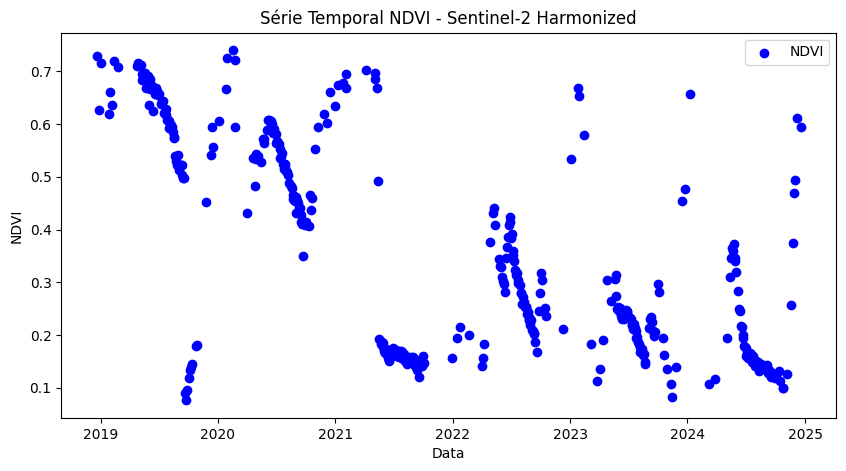

In [246]:
# Plotar o gráfico da série temporal
plt.figure(figsize=(10, 5))
plt.scatter(df["Date"], df["NDVI"], color="blue", label="NDVI")
plt.xlabel("Data")
plt.ylabel("NDVI")
plt.title("Série Temporal NDVI - Sentinel-2 Harmonized")
plt.legend()
plt.grid(False)
plt.xticks(rotation=0)
plt.show()

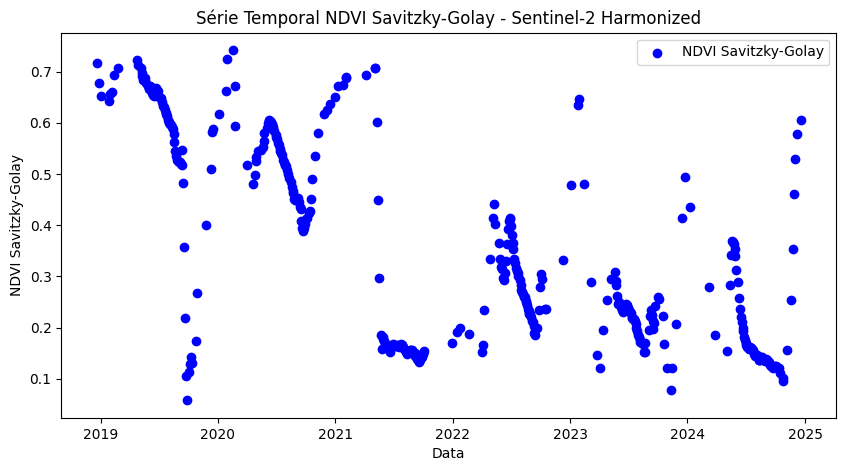

In [247]:

# Plotar o gráfico da série temporal
plt.figure(figsize=(10, 5))
plt.scatter(df["Date"], df["NDVI Savitzky-Golay"], color="blue", label="NDVI Savitzky-Golay")
plt.xlabel("Data")
plt.ylabel("NDVI Savitzky-Golay")
plt.title("Série Temporal NDVI Savitzky-Golay - Sentinel-2 Harmonized")
plt.legend()
plt.grid(False)
plt.xticks(rotation=0)
plt.show()

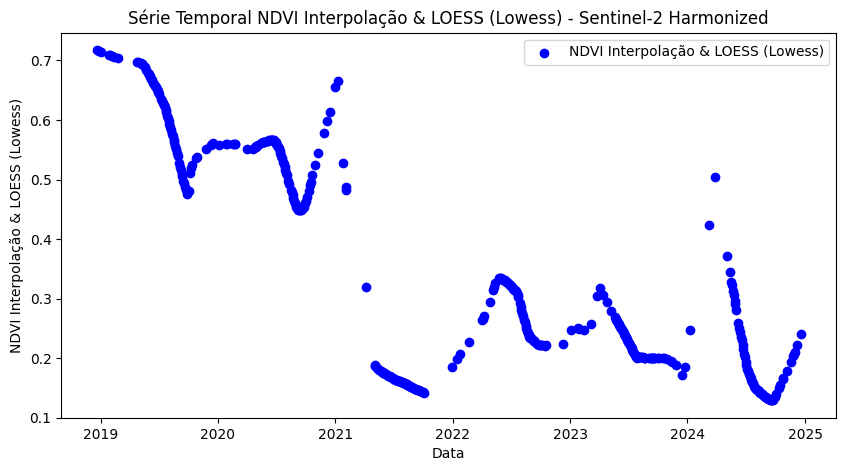

In [248]:
# Plotar o gráfico da série temporal
plt.figure(figsize=(10, 5))
plt.scatter(df["Date"], df["NDVI Interpolação & LOESS (Lowess)"], color="blue", label="NDVI Interpolação & LOESS (Lowess)")
plt.xlabel("Data")
plt.ylabel("NDVI Interpolação & LOESS (Lowess)")
plt.title("Série Temporal NDVI Interpolação & LOESS (Lowess) - Sentinel-2 Harmonized")
plt.legend()
plt.grid(False)
plt.xticks(rotation=0)
plt.show()

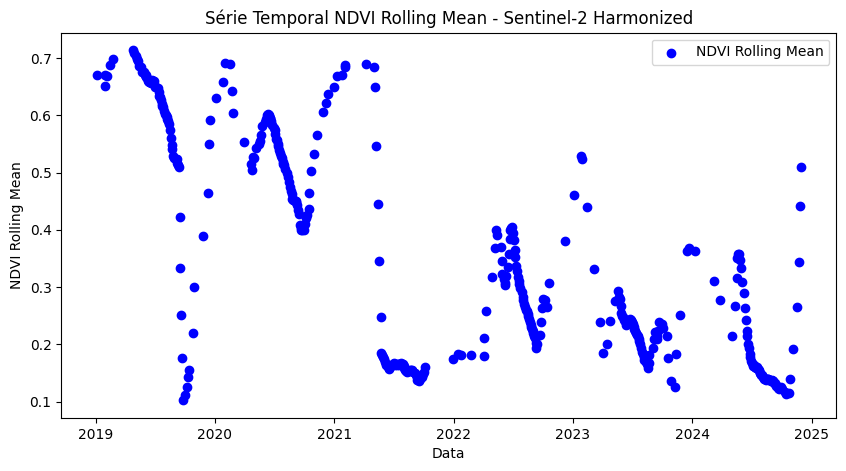

In [249]:
# Plotar o gráfico da série temporal
plt.figure(figsize=(10, 5))
plt.scatter(df["Date"], df["NDVI Rolling Mean"], color="blue", label="NDVI Rolling Mean")
plt.xlabel("Data")
plt.ylabel("NDVI Rolling Mean")
plt.title("Série Temporal NDVI Rolling Mean - Sentinel-2 Harmonized")
plt.legend()
plt.grid(False)
plt.xticks(rotation=0)
plt.show()

In [250]:
import plotly.express as px

# Criar gráfico de dispersão interativo
fig = px.scatter(df, x="Date", y="NDVI", color="NDVI",
                 title="Série Temporal NDVI - Sentinel-2 Harmonized",
                 labels={"NDVI": "NDVI", "Date": "Data"},
                 color_continuous_scale=["brown", "yellow", "green"],
                 size_max=10)

# Adicionar a linha suavizada ao gráfico
fig.add_scatter(x=df["Date"], y=df["NDVI Interpolação & LOESS (Lowess)"], mode="lines",
                name="NDVI Suavizado", line=dict(color="red"))
# fig.add_scatter(x=df["Date"], y=df["NDVI Rolling Mean"], mode="lines",
#                 name="NDVI Suavizado", line=dict(color="blue"))

# Adicionar a linha teórica LandTrendr  ao gráfico
fig.add_scatter(x=['2018-12-16','2021-11-20','2022-09-16', '2023-04-29', '2023-11-15', '2024-04-08', '2024-07-17', '2024-12-09'],
                y=[0.8764,0.8353,0.3329,0.5849,0.2770,0.5448,0.3155,0.3077], mode="lines",
                name="LandTrendr (teórico)", line=dict(color="black"))

# Adicionando anotações para dois pares de coordenadas
fig.add_annotation(x="2021-11-20", y=0.8353,
                   text="Ponto 1",
                   showarrow=True,
                   arrowhead=2,
                   arrowwidth=4,  # Aumentando a espessura da seta
                   ax=70, ay=-40,
                   font=dict(size=16, color="black"))  # Aumentando o tamanho da fonte

fig.add_annotation(x="2022-09-16", y=0.3329,
                   text="Ponto 2",
                   showarrow=True,
                   arrowhead=2,
                   arrowwidth=4,  # Aumentando a espessura da seta
                   ax=-70, ay=40,
                   font=dict(size=16, color="black"))  # Aumentando o tamanho da fonte

# Aumentando os pontos e a espessura da linha
fig.update_traces(
    marker=dict(size=14,  # Tamanho dos pontos
                symbol="square",
                line=dict(width=1, color='grey')  # Contorno dos pontos
               ),
    line=dict(width=4)  # Aumenta a espessura da linha
)

# Melhorar a aparência
fig.update_layout(
    xaxis_title="Data",
    yaxis_title="NDVI",
    # width=1000,  # Largura em pixels
    height=600,  # Altura em pixels
    hovermode="x",
    template="plotly_white"
)

# Formatar data no eixo X para DD/MM/AAAA
fig.update_xaxes(tickformat="%d/%m/%Y")

fig.update_layout(
    legend=dict(
        font=dict(size=14),  # Ajusta o tamanho da fonte da legenda
        yanchor="top",  # Âncora no topo
        y=1.02,  # Move a legenda para cima do gráfico
        xanchor="right",  # Âncora na direita
        x=1,  # Move a legenda para a direita
        orientation="h"  # Deixa a legenda horizontal
    ),
    margin=dict(t=60, l=40, r=40, b=40),  # Ajusta as margens para evitar sobreposição
        coloraxis_colorbar=dict(
        title="NDVI",
        titlefont=dict(size=16),  # Ajusta o tamanho do título da barra de cores
        tickfont=dict(size=12)    # Ajusta o tamanho dos números da escala
    )
)

# Exibir gráfico
fig.show()

In [251]:
from sklearn.linear_model import LinearRegression
import datetime

# Converter para datetime
df['Date'] = pd.to_datetime(df['Date'])

# Converter datas para número de dias desde a primeira data
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

# Criando modelo de regressão linear
model = LinearRegression()
X = df[['Days']]  # Variável independente
y = df['NDVI']  # Variável dependente

# Ajustar o modelo
model.fit(X, y)

# Previsão dos valores ajustados
df['NDVI_Pred'] = model.predict(X)

# # Criar gráfico de dispersão NDVI
# fig = px.scatter(df, x="Date", y="NDVI", color="NDVI",
#                  title="Série Temporal NDVI - Regressão Linear",
#                  labels={"NDVI": "NDVI", "Date": "Data"},
#                  color_continuous_scale="Viridis")

# Criar gráfico de dispersão interativo
fig = px.scatter(df, x="Date", y="NDVI", color="NDVI",
                 title="Série Temporal NDVI - Regressão Linear",
                 labels={"NDVI": "NDVI", "Date": "Data"},
                 color_continuous_scale=["brown", "yellow", "green"],
                 size_max=10)

# Adicionar a linha da regressão linear
fig.add_trace(go.Scatter(x=df['Date'], y=df['NDVI_Pred'],
                         mode='lines', name="Tendência Linear",
                         line=dict(color="red", width=2, dash='dash')))

# Aumentando os pontos e a espessura da linha
fig.update_traces(
    marker=dict(size=14,  # Tamanho dos pontos
                symbol="square",
                line=dict(width=1, color='grey')  # Contorno dos pontos
               ),
    line=dict(width=4)  # Aumenta a espessura da linha
)

# Melhorar a aparência
fig.update_layout(
    xaxis_title="Data",
    yaxis_title="NDVI",
    # width=1000,  # Largura em pixels
    height=600,  # Altura em pixels
    hovermode="x",
    template="plotly_white"
)

# Formatar data no eixo X para DD/MM/AAAA
fig.update_xaxes(tickformat="%d/%m/%Y")

fig.update_layout(
    legend=dict(
        font=dict(size=14),  # Ajusta o tamanho da fonte da legenda
        yanchor="top",  # Âncora no topo
        y=1.02,  # Move a legenda para cima do gráfico
        xanchor="right",  # Âncora na direita
        x=1,  # Move a legenda para a direita
        orientation="h"  # Deixa a legenda horizontal
    ),
    margin=dict(t=60, l=40, r=40, b=40),  # Ajusta as margens para evitar sobreposição
        coloraxis_colorbar=dict(
        title="NDVI",
        titlefont=dict(size=16),  # Ajusta o tamanho do título da barra de cores
        tickfont=dict(size=12)    # Ajusta o tamanho dos números da escala
    )
)

# Mostrar gráfico
fig.show()

# Exibir coeficientes da regressão
slope = model.coef_[0]  # Inclinação
intercept = model.intercept_  # Intercepto
print(f"Equação da reta: NDVI = {slope:.4f} * Dias + {intercept:.4f}")


Equação da reta: NDVI = -0.0002 * Dias + 0.5801


In [252]:
# Calcular resíduos absolutos
df['Desvio_Absoluto'] = abs(df['NDVI'] - df['NDVI_Pred'])

# Encontrar o índice do maior desvio
idx_maior_desvio = df['Desvio_Absoluto'].idxmax()

# Obter o ponto com maior desvio
ponto_maior_desvio = df.loc[idx_maior_desvio]

print(f"Ponto com maior desvio absoluto:")
print(ponto_maior_desvio)


Ponto com maior desvio absoluto:
Date                                  2024-12-07 13:34:40
NDVI                                             0.612344
NDVI Savitzky-Golay                              0.578047
NDVI Interpolação & LOESS (Lowess)               0.222538
NDVI Spline                                      0.567254
NDVI Rolling Mean                                     NaN
Days                                                 2180
NDVI_Pred                                        0.128666
Desvio_Absoluto                                  0.483678
Name: 398, dtype: object


In [253]:
import numpy as np
import scipy.stats as stats
import plotly.graph_objects as go
import pandas as pd

def find_vertices(time, values, max_segments, vertices=None):
    if vertices is None:
        vertices = [0, len(time) - 1]  # Inicializa com os extremos

    while len(vertices) - 1 < max_segments:
        best_vertex = None
        max_residual = 0
        best_segment = None

        for i in range(len(vertices) - 1):
            start = vertices[i]
            end = vertices[i + 1] if i + 1 < len(vertices) else len(time) - 1  # Corrigido para evitar erro

            # Convertendo datas para valores numéricos (dias normalizados)
            x_segment = [(pd.to_datetime(d) - pd.to_datetime(time[0])).days for d in time[start:end+1]]
            x_segment = (np.array(x_segment) - np.min(x_segment)) / (np.max(x_segment) - np.min(x_segment) + 1e-6)
            y_segment = values[start:end+1]

            if len(x_segment) < 2:
                continue  # Pula segmentos muito pequenos

            slope, intercept, _, _, _ = stats.linregress(x_segment, y_segment)
            y_pred = slope * np.array(x_segment) + intercept
            residuals = np.abs(y_segment - y_pred)

            max_residual_idx = np.argmax(residuals) + start
            threshold = 0.03 * np.ptp(values)  # Reduzi para 3% da amplitude dos valores

            if residuals[max_residual_idx - start] > max_residual or residuals[max_residual_idx - start] > threshold:
                max_residual = residuals[max_residual_idx - start]
                best_vertex = max_residual_idx
                best_segment = i

        if best_vertex is None or best_vertex in vertices:
            # Se não encontramos um ponto com erro alto, pegamos o ponto médio do maior segmento
            largest_gap = np.argmax([vertices[i + 1] - vertices[i] for i in range(len(vertices) - 1)])
            best_vertex = (vertices[largest_gap] + vertices[largest_gap + 1]) // 2
            best_segment = largest_gap

        vertices.insert(best_segment + 1, best_vertex)
        print(f"Iteração {len(vertices) - 1}: vértices {vertices}")

    return sorted(vertices)

# Exemplo de uso
time = np.array(dates_list)  # Lista de datas
# values = np.array(df["NDVI Interpolação & LOESS (Lowess)"].to_list())  # Valores de NDVI
values = np.array(df["NDVI Rolling Mean"].to_list())  # Valores de NDVI
values2 = np.array(df["NDVI"].to_list())  # Valores de NDVI

#
#
#
vertices = find_vertices(time, values, max_segments=15)


def find_steepest_decline_with_amplitude(time, values, vertices):
    best_segment = None
    min_slope = float('inf')  # Queremos a menor inclinação (mais negativa)
    max_amplitude = 0  # Queremos a maior amplitude de variação do NDVI

    for i in range(len(vertices) - 1):
        start, end = vertices[i], vertices[i + 1]

        # Convertendo datas para valores numéricos (dias normalizados)
        x_start = (pd.to_datetime(time[start]) - pd.to_datetime(time[0])).days
        x_end = (pd.to_datetime(time[end]) - pd.to_datetime(time[0])).days
        y_start, y_end = values[start], values[end]

        if x_end - x_start == 0:  # Evita divisão por zero
            continue

        slope = (y_end - y_start) / (x_end - x_start)  # Coeficiente angular (inclinação)
        amplitude = abs(y_end - y_start)  # Diferença absoluta no NDVI

        # Critério de escolha: precisamos do declive mais forte *e* da maior amplitude
        if slope < min_slope or (slope == min_slope and amplitude > max_amplitude):
            min_slope = slope
            max_amplitude = amplitude
            best_segment = (start, end)

    if best_segment:
        start_date = pd.to_datetime(time[best_segment[0]]).strftime('%Y-%m-%d')
        end_date = pd.to_datetime(time[best_segment[1]]).strftime('%Y-%m-%d')
    else:
        start_date, end_date = None, None

    return best_segment, min_slope, max_amplitude, start_date, end_date

def find_surrounding_dates(time, best_segment):
    """Retorna 2 datas antes e 2 depois do segmento selecionado."""
    start_idx, end_idx = best_segment
    time_series = pd.to_datetime(time)

    # Pegando os índices antes e depois
    before_dates = time_series[max(0, start_idx - 10):start_idx]
    after_dates = time_series[end_idx + 1:min(len(time), end_idx + 5)]

    # Convertendo para o formato 'yyyy-mm-dd' sem o atributo .dt
    before_dates = [d.strftime('%Y-%m-%d') for d in before_dates]
    after_dates = [d.strftime('%Y-%m-%d') for d in after_dates]

    return before_dates, after_dates

def remove_flat_segments(time, values, vertices, threshold=0.01):
    """Remove segmentos com inclinação quase horizontal."""
    filtered_vertices = [vertices[0]]  # Sempre manter o primeiro vértice

    for i in range(len(vertices) - 1):
        start, end = vertices[i], vertices[i + 1]

        # Convertendo datas para valores numéricos (dias normalizados)
        x_start = (pd.to_datetime(time[start]) - pd.to_datetime(time[0])).days
        x_end = (pd.to_datetime(time[end]) - pd.to_datetime(time[0])).days
        y_start, y_end = values[start], values[end]

        if x_end - x_start == 0:
            continue  # Evita divisão por zero

        slope = (y_end - y_start) / (x_end - x_start)  # Coeficiente angular

        # Adiciona o vértice final do segmento se a inclinação for significativa
        if abs(slope) >= threshold:
            filtered_vertices.append(end)

    return filtered_vertices


# Aplicando a filtragem de segmentos horizontais
filtered_vertices = remove_flat_segments(time, values, vertices, threshold=0.0001)

# Recalculando o segmento mais inclinado após a filtragem
# steepest_segment, min_slope, max_amplitude, start_date, end_date = find_steepest_decline_with_amplitude(time, values, filtered_vertices)

# Encontrar o segmento com maior declive negativo e maior amplitude
steepest_segment, min_slope, max_amplitude, start_date, end_date = find_steepest_decline_with_amplitude(time, values, vertices)

# Encontrar as 2 datas antes e 2 depois
before_dates, after_dates = find_surrounding_dates(time, steepest_segment)

# Corrigindo a busca pelos valores NDVI
time_strings = [pd.to_datetime(d).strftime('%Y-%m-%d') for d in time]  # Converte a série de datas para strings
all_dates = before_dates + [start_date, end_date] + after_dates

# Agora encontramos os índices corretamente
all_values = [values[time_strings.index(date)] for date in all_dates if date in time_strings]

# Criar o gráfico de dispersão do NDVI
fig = px.scatter(df, x="Date", y="NDVI", color="NDVI",
                 title="Série Temporal NDVI - Sentinel-2 Harmonized",
                 labels={"NDVI": "NDVI", "Date": "Data"},
                 color_continuous_scale=["brown", "yellow", "green"],
                 size_max=10)

fig.add_trace(go.Scatter(x=[time[i] for i in vertices], y=[values[i] for i in vertices],
                         mode='lines+markers', name='LandTrendr Vertices', line=dict(color='black', width=2)))

fig.update_layout(title='Detecção de Vértices com LandTrendr', xaxis_title='Ano', yaxis_title='NDVI', template='plotly_white')

# Melhorar a aparência
fig.update_layout(
    xaxis_title="Data",
    yaxis_title="NDVI",
    # width=1000,  # Largura em pixels
    height=600,  # Altura em pixels
    hovermode="x",
    template="plotly_white"
)

# Formatar data no eixo X para DD/MM/AAAA
fig.update_xaxes(tickformat="%d/%m/%Y")

fig.update_layout(
    legend=dict(
        font=dict(size=14),  # Ajusta o tamanho da fonte da legenda
        yanchor="top",  # Âncora no topo
        y=1.02,  # Move a legenda para cima do gráfico
        xanchor="right",  # Âncora na direita
        x=1,  # Move a legenda para a direita
        orientation="h"  # Deixa a legenda horizontal
    ),
    margin=dict(t=60, l=40, r=40, b=40),  # Ajusta as margens para evitar sobreposição
        coloraxis_colorbar=dict(
        title="NDVI",
        titlefont=dict(size=16),  # Ajusta o tamanho do título da barra de cores
        tickfont=dict(size=12)    # Ajusta o tamanho dos números da escala
    )
)

# Exibir resultados
if steepest_segment:
    print(f"Segmento de maior declive negativo com maior amplitude: {steepest_segment}")
    print(f"Inclinação mais negativa: {min_slope:.6f}")
    print(f"Amplitude do NDVI: {max_amplitude:.6f}")
    print(f"Data inicial: {start_date}")
    print(f"Data final: {end_date}")
    # print(f"Datas antes: {before_dates}")
    # print(f"Datas depois: {after_dates}")

    # Adicionar ao gráfico
    fig.add_trace(go.Scatter(
        x=[time[steepest_segment[0]], time[steepest_segment[1]]],
        y=[values[steepest_segment[0]], values[steepest_segment[1]]],
        mode='lines+markers',
        name='Maior Declive + Amplitude',
        line=dict(color='red', width=6)
    ))

else:
    print("Nenhum segmento com declive significativo encontrado.")


# Aumentando os pontos e a espessura da linha
fig.update_traces(
    marker=dict(size=14,  # Tamanho dos pontos
                symbol="square",
                line=dict(width=1, color='grey')  # Contorno dos pontos
               ),
    line=dict(width=4)  # Aumenta a espessura da linha
)

fig.show()

print("Vértices detectados nas posições:", vertices)


Iteração 2: vértices [0, 199, 399]
Iteração 3: vértices [0, 199, 299, 399]
Iteração 4: vértices [0, 199, 266, 299, 399]
Iteração 5: vértices [0, 99, 199, 266, 299, 399]
Iteração 6: vértices [0, 99, 148, 199, 266, 299, 399]
Iteração 7: vértices [0, 99, 148, 199, 266, 299, 349, 399]
Iteração 8: vértices [0, 49, 99, 148, 199, 266, 299, 349, 399]
Iteração 9: vértices [0, 49, 99, 148, 199, 232, 266, 299, 349, 399]
Iteração 10: vértices [0, 49, 99, 148, 173, 199, 232, 266, 299, 349, 399]
Iteração 11: vértices [0, 49, 60, 99, 148, 173, 199, 232, 266, 299, 349, 399]
Iteração 12: vértices [0, 49, 60, 73, 99, 148, 173, 199, 232, 266, 299, 349, 399]
Iteração 13: vértices [0, 49, 60, 73, 99, 148, 173, 199, 232, 266, 299, 324, 349, 399]
Iteração 14: vértices [0, 49, 60, 73, 99, 148, 173, 199, 232, 266, 299, 324, 349, 374, 399]
Iteração 15: vértices [0, 24, 49, 60, 73, 99, 148, 173, 199, 232, 266, 299, 324, 349, 374, 399]
Segmento de maior declive negativo com maior amplitude: (49, 60)
Inclinação ma

Vértices detectados nas posições: [0, 24, 49, 60, 73, 99, 148, 173, 199, 232, 266, 299, 324, 349, 374, 399]


In [255]:
import folium
import geemap.foliumap as geemap

# Definir as datas desejadas
# date1 = '2022-04-24'
date1 = start_date #'2021-10-01'
date2 = end_date #'2022-09-16'

# Parâmetros de visualização
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB (Red, Green, Blue)
    'min': 300,
    'max': 3000,
    'gamma': 1.2
}

# Obter centro da AOI
centroid = AOI.centroid(10).coordinates().getInfo()
lat, lon = centroid[1], centroid[0]

# Criar mapa interativo centrado no AOI
mapa = geemap.Map(center=[lat, lon], zoom=12)

for before_date in list(set(before_dates)):
    # Filtro pelo dia exato
    img1 = collection.filter(ee.Filter.date(before_date, ee.Date(before_date).advance(1, 'day'))).first()

    # Adicionar camadas das imagens ao mapa
    mapa.addLayer(img1, vis_params, f"Antes: Sentinel-2 ({before_date})")

for after_date in list(set(after_dates)):
    # Filtro pelo dia exato
    img2 = collection.filter(ee.Filter.date(after_date, ee.Date(after_date).advance(1, 'day'))).first()

    # Adicionar camadas das imagens ao mapa
    mapa.addLayer(img2, vis_params, f"Depois: Sentinel-2 ({after_date})")

# Adiciona a AOI no mapa
mapa.addLayer(ee.FeatureCollection(AOI).style(fillColor='ffffff00', color='ff0000'), {}, 'Alerta')

# Adicionar controles
mapa.addLayerControl()

# Exibir mapa
mapa
